## Tensor RNN for long term forecasting demo 
- seq2seq architecture with tensor RNN cell
- variable length of forecasting horizon
- flexible temporal high order structure

### step 1: Flags for training configuration

In [1]:
"""Functions for downloading and reading time series data."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import random_seed

import tensorflow as tf
from tensorflow.contrib import rnn
from reader import read_data_sets
from model_seq2seq import *
from trnn import *
import numpy 
from train_config import *


flags = tf.flags

flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string("model", "TLSTM", "Model used for learning.")
flags.DEFINE_string("data_path", "./data.npy", "Data input directory.")
flags.DEFINE_string("save_path", "./log/tlstm/", "Model output directory.")
flags.DEFINE_bool("use_sched_samp", False, "Use scheduled sampling in training")
flags.DEFINE_integer("inp_steps", 12, "burn in steps")
flags.DEFINE_integer("out_steps", None, "test steps")
flags.DEFINE_integer("hidden_size", 8, "hidden layer size")
flags.DEFINE_float("learning_rate", 1e-3, "learning rate")
flags.DEFINE_float("decay_rate", 0.8, "decay rate")
flags.DEFINE_integer("rank", 1, "rank for tt decomposition")
flags.DEFINE_integer("num_lags", 3, "time-lag length")
flags.DEFINE_integer("num_layers", 2, "time-lag length")

FLAGS = flags.FLAGS
print('Flags configuration loaded ...')

Flags configuration loaded ...


### step 2: Read flags and data into memory

In [2]:
'''
To forecast time series using a recurrent neural network, we consider every 
row as a sequence of short time series.
'''

# Training Parameters
config = TrainConfig()
config.hidden_size = FLAGS.hidden_size
config.learning_rate = FLAGS.learning_rate
config.decay_rate = FLAGS.decay_rate
config.rank_vals = [FLAGS.rank]
config.num_lags = FLAGS.num_lags
config.num_layers = FLAGS.num_layers

# Scheduled sampling [optional]
if FLAGS.use_sched_samp:
    config.sample_prob = tf.get_variable("sample_prob", shape=(), initializer=tf.zeros_initializer())
sampling_burn_in = 400

# Training Parameters
training_steps = config.training_steps
batch_size = config.batch_size
display_step = 500
inp_steps = config.inp_steps
out_steps = FLAGS.out_steps


# Read Dataset
dataset, stats = read_data_sets(FLAGS.data_path, True, inp_steps, out_steps)

# Network Parameters
num_input = stats['num_input']  # dataset data input (time series dimension: 1)
num_steps = stats['num_steps']

if out_steps is None:
    # Forecast for the rest if horizon is not set
    out_steps = num_steps - inp_steps

# Print training config
print('-'*100)
print('|input steps|', inp_steps, 
      '|out steps|', out_steps,
      '|hidden size|', config.hidden_size, 
      '|learning rate|', config.learning_rate, 
      '|rank val|', config.rank_vals
     )
print('-'*100)

loading time series ...
input type  <class 'numpy.ndarray'> (1000, 100, 1)
normalize to (0-1)
----------------------------------------------------------------------------------------------------
|input steps| 12 |out steps| 88 |hidden size| 8 |learning rate| 0.001 |rank val| [1]
----------------------------------------------------------------------------------------------------


### visualize time series samples
load the raw data into the notebook to visualize

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# print("loading time series ...")
# data = np.load(FLAGS.data_path)
# # # Expand the dimension if univariate time series
# # if (np.ndim(data)==1):
# #         data = np.expand_dims(data, axis=1)
# # plot = plt.plot(data[:,:,0].T)

# data.shape

### Step 3: Build neural network models
Building seq2seq model for training/validation/testing,
validation and testing models are shared,
scheduled sampling is by default off 

In [4]:
# tf Graph input
X = tf.placeholder("float", [None, inp_steps, num_input])
Y = tf.placeholder("float", [None, out_steps, num_input])

# Decoder output
Z = tf.placeholder("float", [None, out_steps, num_input])

Model = globals()[FLAGS.model]
with tf.name_scope("Train"):
    with tf.variable_scope("Model", reuse=None):
        train_pred = Model(X, Y, True,  config)
with tf.name_scope("Valid"):
    with tf.variable_scope("Model", reuse=True):
        valid_pred = Model(X, Y, False,  config)
with tf.name_scope("Test"):
    with tf.variable_scope("Model", reuse=True):
        test_pred = Model(X, Y, False,  config)


# Define loss and optimizer
train_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(train_pred, Z)))
test_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(test_pred, Z)))
valid_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(valid_pred, Z)))

# Exponential learning rate decay 
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = config.learning_rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                           global_step,
                                           2000, 
                                           config.decay_rate, 
                                           staircase=True
                                          )
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_op = optimizer.minimize(train_loss,global_step=global_step)

# Scheduled sampling params
eps_min = 0.1 # minimal prob

# Write summary
train_summary = tf.summary.scalar('train_loss', train_loss)
valid_summary = tf.summary.scalar('valid_loss', valid_loss)
lr_summary = tf.summary.scalar('learning_rate', learning_rate)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Saver for the model and loss
saver = tf.train.Saver()
hist_loss =[]

Training -->
          Create Encoder ...
          Create Decoder ...
Testing -->
          Create Encoder ...
          Create Decoder ...
Testing -->
          Create Encoder ...
          Create Decoder ...


### Training loop
This may take a while, training loss is displayed at every 500 steps, 
use GPU can speed up training

In [5]:
# Start training
training_steps = 1000
with tf.Session() as sess:
    # Merge all the summaries and write them out to /log/tlstm (by default)
    merged = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(FLAGS.save_path,sess.graph)

    # Run the initializer
    sess.run(init)    
    
    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_z = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, ## i.e. optimizer.minimize(train_loss,global_step=global_step)
                 feed_dict={X: batch_x, Y: batch_y, Z:batch_z}
                )
        if step % display_step == 0 or step == 1:
            # Calculate batch loss 
            summary, loss = sess.run([merged,train_loss], 
                                     feed_dict={X: batch_x,Y: batch_y, Z:batch_z}
                                    )
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            summary_writer.add_run_metadata(run_metadata, 'step%03d' % step)
            summary_writer.add_summary(summary, step)
            print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(loss) )
            
            # Calculate validation
            valid_enc_inps = dataset.validation.enc_inps.reshape((-1, inp_steps, num_input))
            valid_dec_inps = dataset.validation.dec_inps.reshape((-1, out_steps, num_input))
            valid_dec_outs = dataset.validation.dec_outs.reshape((-1, out_steps, num_input))
            va_sum, va_loss = sess.run([valid_summary,valid_loss],
                                       feed_dict={X: valid_enc_inps, Y: valid_dec_inps, Z: valid_dec_outs}
                                      )
            summary_writer.add_summary(va_sum, step) 
            print("Validation Loss:", va_loss)
            
            # Overfitting
            hist_loss.append(va_loss)
            if len(hist_loss)>20 and va_loss > np.mean(hist_loss):
                print("Early stopping: step ", step)
                break
          
            #Update sampling prob
            if FLAGS.use_sched_samp and step > sampling_burn_in:
                sample_prob = max(eps_min, 1.0-step/(2*training_steps))
                sess.run(tf.assign(config.sample_prob, sample_prob))
                print('Sampling prob:', sample_prob)

    print("Optimization Finished!")

    # Calculate accuracy for test datasets
    test_enc_inps = dataset.test.enc_inps.reshape((-1, inp_steps, num_input))
    test_dec_inps = dataset.test.dec_inps.reshape((-1, out_steps, num_input))
    test_dec_outs = dataset.test.dec_outs.reshape((-1, out_steps, num_input))

    
    # Fetch the predictions 
    fetches = {
        "true":Z,
        "pred":test_pred,
        "loss":test_loss
    }
    test_vals = sess.run(fetches, 
                         feed_dict={X: test_enc_inps, Y: test_dec_inps, Z: test_dec_outs}
                        )
    print("Testing Loss:", test_vals["loss"])

    # Save the variables to disk.
    save_path = saver.save(sess, FLAGS.save_path)
    print("Model saved in file: %s" % save_path)
    # Save predictions 
    numpy.save(save_path+"predict.npy", (test_vals["true"], test_vals["pred"]))
    # Save config file
    with open(save_path+"config.out", 'w') as f:
        f.write('hidden_size:'+ str(config.hidden_size)+'\n'+ 'learning_rate:'+ str(config.learning_rate)+ '\n')
        f.write('train_error:'+ str(loss) +'\n'+ 'valid_error:' + str(va_loss) + '\n'+ 'test_error:'+ str(test_vals["loss"]) +'\n')

Step 1, Minibatch Loss= 0.4920
Validation Loss: 0.48893404
Step 500, Minibatch Loss= 0.1253
Validation Loss: 0.12080283
Step 1000, Minibatch Loss= 0.0774
Validation Loss: 0.07078586
Optimization Finished!
Testing Loss: 0.07688681
Model saved in file: ./log/tlstm/


### Visualize predictions

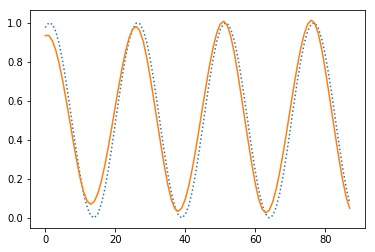

In [6]:
y_true = test_vals["true"]
y_pred = test_vals["pred"]
plt.plot(y_true[0,:,0].T,':')
plt.plot(y_pred[0,:,0].T,'-')